# Generating Chirp

In [33]:
import math
import cmath
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm

In [2]:
def polynomialPhase(coeffs:list,t:int)->int:
    """
    Generate the polynomial phase 
    """
    total = 0
    for i in range(1,len(coeffs)+1):
        total += coeffs[i-1]*(t**i/math.factorial(i))
    return total

In [3]:
def chirp(coeffs:list,nS:int,f:int)->list:
    """
    Generate a sample chirp given coeffs, number of samples and frequency 
    """
    outer = []
    for n in range (0,nS):
        temp = cmath.exp(2j*math.pi*(polynomialPhase(coeffs,n/f)))
        outer.append(temp)
    return outer

In [4]:
nSamples = 10000
samplingFrequency = 2000
def plot_chirp(coeffs:list)->list:
    p = chirp(coeffs,nSamples,samplingFrequency)
    points = [i.real for i in p]
    plt.plot(points)
    return p

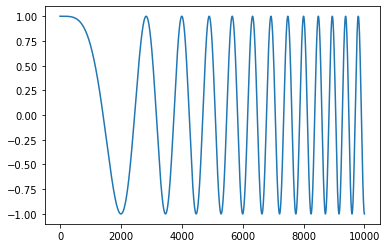

In [5]:
p = plot_chirp([0,1])

# Generating White Noise

In [6]:
def complexWhiteNoise(nS:int)->list:
    realDist = np.random.normal(0,1/math.sqrt(2),nS)
    imgDist = np.random.normal(0,1/math.sqrt(2),nS)
    return realDist + imgDist*1j

In [7]:
snr = 10
whiteNoisePoints = complexWhiteNoise(nSamples)/(10**(snr/20))
noisyPoints = p + whiteNoisePoints

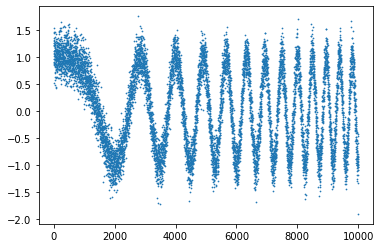

In [8]:
plt.scatter(range(0,len(noisyPoints)),noisyPoints.real,s=0.5)

# Normalizing 

In [9]:
def normalize(v:list)->list:
    return v / np.linalg.norm(v)

In [10]:
def normalizedMF(signal:list,template:list)->list:
    return np.correlate(normalize(signal),normalize(template),mode="full")

In [11]:
plot_n = normalizedMF(np.array(noisyPoints),np.array(p))

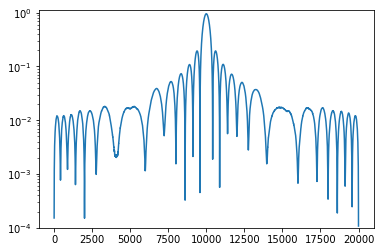

In [12]:
plt.plot([abs(i) for i in plot_n])
plt.yscale("log")
plt.ylim(10**-4, 1.1);

# Concatenate Matched Filter Outputs

In [13]:
def allAbsMFOutputs(signal:list,template:list)->list:
    outputs = [normalizedMF(signal,i) for i in template]
    return abs(np.concatenate(outputs))

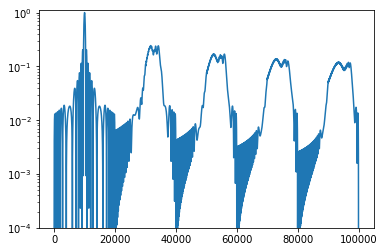

In [14]:
list_of_chirps = (
            chirp([0,1],nSamples,samplingFrequency),
            chirp([0,2],nSamples,samplingFrequency),
            chirp([0,3],nSamples,samplingFrequency),
            chirp([0,4],nSamples,samplingFrequency),
            chirp([0,5],nSamples,samplingFrequency)
        )
plt.plot(allAbsMFOutputs(chirp([0,1],nSamples,samplingFrequency),list_of_chirps));
plt.yscale("log")
plt.ylim(10**-4, 1.1);

# Real-Life Values

In [15]:
param_dict = {"Air Mode 1":[9750,1],"Air Mode 2":[9750,30],"Air Mode 3":[9750,14],"Air Mode 4":[9750,29],
               "Weather Mode 1":[9500,382],"Weather Mode 2":[9500,131],"Weather Mode 3":[9500,1000],
               "Weather Mode 4":[9500,375],"Weather Mode 5":[9500,300],"Marine Mode 1":[9410,400],
               "Marine Mode 2":[9410,111],"Marine Mode 3":[9410,440],"Marine Mode 4":[9410,500],
               "Marine Mode 5":[9410,139],"Marine Mode 6":[9410,50]}

In [16]:
samplingFrequency = 1200
nSamples = 10000

# Data Prep

In [18]:
chirp1 = allAbsMFOutputs(chirp([0,1],nSamples,samplingFrequency),list_of_chirps)
chirp2 = allAbsMFOutputs(chirp([0,2],nSamples,samplingFrequency),list_of_chirps)
chirp3 = allAbsMFOutputs(chirp([0,3],nSamples,samplingFrequency),list_of_chirps)
chirp4 = allAbsMFOutputs(chirp([0,4],nSamples,samplingFrequency),list_of_chirps)
chirp5 = allAbsMFOutputs(chirp([0,5],nSamples,samplingFrequency),list_of_chirps)

In [29]:
pd.DataFrame({1:chirp1,2:chirp2,3:chirp3,4:chirp4,5:chirp5}).to_csv('output.csv',index=False)

In [32]:
chirp_dataset = pd.read_csv('output.csv')

In [34]:
chirp_dataset

,1,2,3,4,5
0,0.000100,0.000100,0.000100,0.000100,0.000100
1,0.000200,0.000200,0.000200,0.000200,0.000200
2,0.000300,0.000300,0.000300,0.000300,0.000300
3,0.000400,0.000400,0.000400,0.000400,0.000400
4,0.000500,0.000500,0.000500,0.000500,0.000500
...,...,...,...,...,...
99990,0.000499,0.000496,0.000491,0.000485,0.000477
99991,0.000400,0.000398,0.000396,0.000392,0.000388
99992,0.000300,0.000299,0.000298,0.000297,0.000295
99993,0.000200,0.000200,0.000200,0.000199,0.000199


# Training Model

In [50]:
X = []
y = []
for i in chirp_dataset:
    X.append(list(chirp_dataset[i]))
    y += i

In [51]:
clf = svm.SVC()

In [52]:
clf.fit(X,y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [64]:
x_predict = np.array(chirp_dataset['2']).reshape(1,-1)
clf.predict(x_predict)

array(['2'], dtype='<U1')